In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from models import Model

In [3]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

In [4]:
batch_size = 32
shuffle = True
num_workers = 4

In [5]:
train_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=train_transform,
                                             download=True)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size,
                                               shuffle=shuffle, num_workers=num_workers)

test_dataset = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,
                                              num_workers=num_workers)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
images, labels = next(iter(train_dataloader))

In [7]:
images[0].shape, labels[0]

(torch.Size([3, 32, 32]), tensor(4))

In [8]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
def imshow(img, label=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if label is not None:
        plt.title(train_dataset.classes[label.item()])
    plt.show()

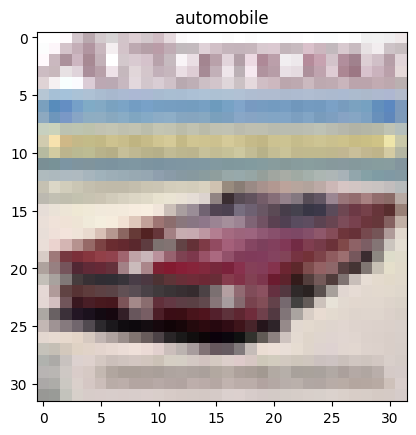

In [10]:
imshow(torchvision.utils.make_grid(tensor=[images[30]]),  label=labels[30])

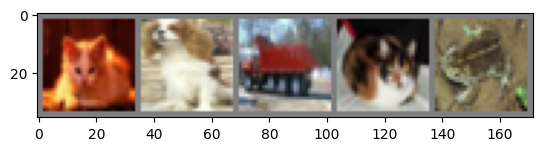

In [11]:
imshow(torchvision.utils.make_grid(images[2:7]))

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model().to(device)

summary(model, input_size=(3,32,32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 32, 32]             108
              ReLU-2            [-1, 4, 32, 32]               0
       BatchNorm2d-3            [-1, 4, 32, 32]               8
            Conv2d-4            [-1, 8, 32, 32]             288
              ReLU-5            [-1, 8, 32, 32]               0
       BatchNorm2d-6            [-1, 8, 32, 32]              16
            Conv2d-7            [-1, 4, 32, 32]              32
              ReLU-8            [-1, 4, 32, 32]               0
         MaxPool2d-9            [-1, 4, 16, 16]               0
           Conv2d-10            [-1, 4, 16, 16]             144
             ReLU-11            [-1, 4, 16, 16]               0
      BatchNorm2d-12            [-1, 4, 16, 16]               8
           Conv2d-13            [-1, 8, 16, 16]             288
             ReLU-14            [-1, 8,

In [14]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

epoch_train_loss = []
epoch_train_acc = []
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)
    epoch_train_loss.append(sum(train_losses[-train_loader.batch_size:])/(train_loader.batch_size))
    epoch_train_acc.append(train_acc[-1])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [18]:
model =  Model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

EPOCH: 1


Loss=1.5676265954971313 Batch_id=1562 Accuracy=34.10: 100%|██████████| 1563/1563 [00:12<00:00, 127.95it/s]



Test set: Average loss: 1.5594, Accuracy: 4173/10000 (41.73%)

EPOCH: 2


Loss=1.3002787828445435 Batch_id=1562 Accuracy=45.84: 100%|██████████| 1563/1563 [00:10<00:00, 143.99it/s]



Test set: Average loss: 1.4374, Accuracy: 4608/10000 (46.08%)

EPOCH: 3


Loss=1.2132700681686401 Batch_id=1562 Accuracy=50.15: 100%|██████████| 1563/1563 [00:10<00:00, 142.75it/s]



Test set: Average loss: 1.3222, Accuracy: 5101/10000 (51.01%)

EPOCH: 4


Loss=1.7641011476516724 Batch_id=1562 Accuracy=52.01: 100%|██████████| 1563/1563 [00:10<00:00, 142.28it/s]



Test set: Average loss: 1.2816, Accuracy: 5325/10000 (53.25%)

EPOCH: 5


Loss=1.5903708934783936 Batch_id=1562 Accuracy=53.99: 100%|██████████| 1563/1563 [00:11<00:00, 131.75it/s]



Test set: Average loss: 1.2302, Accuracy: 5468/10000 (54.68%)

EPOCH: 6


Loss=1.3664031028747559 Batch_id=1562 Accuracy=54.99: 100%|██████████| 1563/1563 [00:10<00:00, 142.92it/s]



Test set: Average loss: 1.2118, Accuracy: 5619/10000 (56.19%)

EPOCH: 7


Loss=1.178422212600708 Batch_id=1562 Accuracy=56.20: 100%|██████████| 1563/1563 [00:11<00:00, 141.53it/s] 



Test set: Average loss: 1.2054, Accuracy: 5577/10000 (55.77%)

EPOCH: 8


Loss=1.855560064315796 Batch_id=1562 Accuracy=57.23: 100%|██████████| 1563/1563 [00:10<00:00, 142.09it/s] 



Test set: Average loss: 1.1915, Accuracy: 5711/10000 (57.11%)

EPOCH: 9


Loss=1.1130427122116089 Batch_id=1562 Accuracy=57.90: 100%|██████████| 1563/1563 [00:11<00:00, 141.86it/s]



Test set: Average loss: 1.1560, Accuracy: 5846/10000 (58.46%)

EPOCH: 10


Loss=1.4757317304611206 Batch_id=1562 Accuracy=58.32: 100%|██████████| 1563/1563 [00:11<00:00, 139.06it/s]



Test set: Average loss: 1.1954, Accuracy: 5744/10000 (57.44%)

EPOCH: 11


Loss=1.032947301864624 Batch_id=1562 Accuracy=58.82: 100%|██████████| 1563/1563 [00:11<00:00, 135.79it/s] 



Test set: Average loss: 1.1687, Accuracy: 5852/10000 (58.52%)

EPOCH: 12


Loss=1.4349507093429565 Batch_id=1562 Accuracy=59.49: 100%|██████████| 1563/1563 [00:11<00:00, 140.00it/s]



Test set: Average loss: 1.1109, Accuracy: 6068/10000 (60.68%)

EPOCH: 13


Loss=1.5099782943725586 Batch_id=1562 Accuracy=60.04: 100%|██████████| 1563/1563 [00:11<00:00, 141.25it/s]



Test set: Average loss: 1.1364, Accuracy: 5913/10000 (59.13%)

EPOCH: 14


Loss=0.9467635750770569 Batch_id=1562 Accuracy=60.57: 100%|██████████| 1563/1563 [00:11<00:00, 138.33it/s]



Test set: Average loss: 1.1221, Accuracy: 6030/10000 (60.30%)

EPOCH: 15


Loss=0.9473912715911865 Batch_id=1562 Accuracy=60.75: 100%|██████████| 1563/1563 [00:11<00:00, 141.71it/s]



Test set: Average loss: 1.1288, Accuracy: 6007/10000 (60.07%)

EPOCH: 16


Loss=1.0993319749832153 Batch_id=1562 Accuracy=60.96: 100%|██████████| 1563/1563 [00:11<00:00, 130.73it/s]



Test set: Average loss: 1.0777, Accuracy: 6155/10000 (61.55%)

EPOCH: 17


Loss=1.0571209192276 Batch_id=1562 Accuracy=61.29: 100%|██████████| 1563/1563 [00:11<00:00, 140.57it/s]   



Test set: Average loss: 1.1209, Accuracy: 5984/10000 (59.84%)

EPOCH: 18


Loss=1.1760669946670532 Batch_id=1562 Accuracy=61.49: 100%|██████████| 1563/1563 [00:11<00:00, 141.17it/s] 



Test set: Average loss: 1.0808, Accuracy: 6145/10000 (61.45%)

EPOCH: 19


Loss=1.192681074142456 Batch_id=1562 Accuracy=61.64: 100%|██████████| 1563/1563 [00:11<00:00, 139.78it/s] 



Test set: Average loss: 1.1025, Accuracy: 6031/10000 (60.31%)

EPOCH: 20


Loss=1.1814353466033936 Batch_id=1562 Accuracy=62.01: 100%|██████████| 1563/1563 [00:11<00:00, 141.65it/s]



Test set: Average loss: 1.0752, Accuracy: 6171/10000 (61.71%)

